<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN architectures.
We want to start from scratch and get an idea of how different architectures work before fitting to some data.


We the fit these to sequential behavioural decision making later.


In [1]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [112]:
# set paths not on google colab
from pathlib import Path
import os
#CODE_DIR = Path(Path(r'.'))
#os.chdir(CODE_DIR)
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


In [113]:
# Import packages and local code
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.models import parallelised_training as pat
from importlib import reload #for active development


In [115]:
# Train some models using the standard code
reload(training)
reload(datasets)

CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'
SEQUENCE_LENGTH = 150+1 # sequence length for batched training


dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(input_size=3, # past forced choice, past choice, past outcome, 
                     hidden_size=1, # hidden unit
                     out_size=2, # one-hot code for choice A, choice B
                     rnn_type='GRU', # GRU, LSTM, NMRNN, vanilla,
                     nm_mode = 'low_rank',
                     nm_dim=1,
                     nm_size=1,
                     input_forced_choice=False,
                     )  
trainer = training.Trainer(SAVE_PATH/'test',batch_size = 8, 
                                            max_epochs = 100, 
                                            early_stop = 20,
                                            random_seed = 42,
                                            sparsity_lambda = [1e-2]
                                            )
training_losses_df = trainer.fit(model,dataset)


Starting training with 1 sparsity values...
Dataset size: 51
Split sizes - Train: 40, Validation: 5, Evaluation: 6

Training with sparsity lambda = 0.01


λ=1e-02: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]



Evaluating best model (λ=1e-02) on test set...
Evaluation loss: 0.566433

Training complete!
Best model (λ=1e-02) saved to: NM_TinyRNN/data/rnns/test
Best validation loss: 0.576602
Test loss: 0.566433
Lastly, extracting activations on full dataset


In [118]:
#good poke alignment is off. Need to debug !!
n_trials = dataset.inputs.shape[0]*dataset.inputs.shape[1]
dataset.subject_df.forced_choice[:n_trials] == dataset.inputs.reshape(n_trials,3)[:n_trials,0]

0      False
1      False
2      False
3      False
4      False
       ...  
254    False
255    False
256    False
257    False
258    False
Name: forced_choice, Length: 7650, dtype: bool

In [119]:
dataset.inputs.reshape(n_trials,3)

tensor([[1., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        ...,
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.]])

In [121]:
dataset.subject_df[:n_trials]

,forced_choice,choice,outcome,good_poke
0,True,poke_4,True,poke_6
1,False,poke_4,True,poke_6
2,False,poke_4,False,poke_6
3,False,poke_4,False,poke_6
4,True,poke_6,True,poke_6
...,...,...,...,...
254,False,poke_6,False,poke_6
255,False,poke_6,False,poke_6
256,False,poke_4,False,poke_6
257,False,poke_4,False,poke_6


In [ ]:
good_pokes = (filtered_df['choice'] != filtered_df['good_poke'])
filtered_df.loc[good_pokes,'outcome'].mean()

np.float64(0.5894417014812001)

In [98]:
n_trials = len(trial_data)
trial_data['good_poke'] = dataset.subject_df['good_poke'].astype('category').cat.codes.iloc[:n_trials]
filtered_df = trial_data.query('forced_choice == 0')

In [92]:
filtered_df = dataset.subject_df.query('forced_choice==0')
good_pokes = (filtered_df['choice'] == filtered_df['good_poke'])
filtered_df.loc[good_pokes,'outcome'].mean()

np.float64(0.7437262357414449)

In [106]:
test = torch.tensor([1,2,3,4,5,6,7,8,9,10])
test = test.view(2,5,1)
test.reshape(10,1)

tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]])

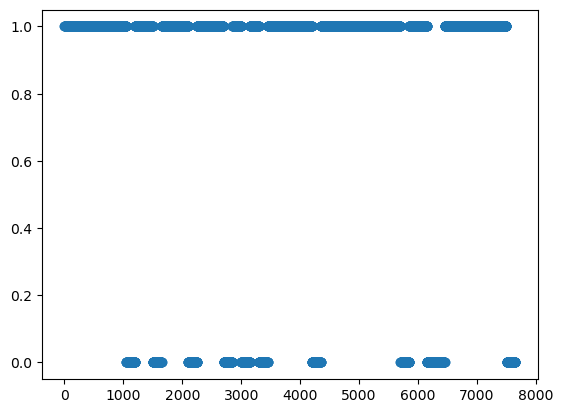

In [103]:
plt.scatter(x=np.arange(len(trial_data)),y=trial_data['indices_train'])

In [93]:
dataset.subject_df

,forced_choice,choice,outcome,good_poke
0,True,poke_4,True,poke_6
1,False,poke_4,True,poke_6
2,False,poke_4,False,poke_6
3,False,poke_4,False,poke_6
4,True,poke_6,True,poke_6
...,...,...,...,...
444,False,poke_6,True,poke_6
445,True,poke_4,False,poke_6
446,False,poke_6,True,poke_6
447,False,poke_6,False,poke_6


In [61]:
dataset.subject_df

,forced_choice,choice,outcome,good_poke
0,True,poke_4,True,poke_6
1,False,poke_4,True,poke_6
2,False,poke_4,False,poke_6
3,False,poke_4,False,poke_6
4,True,poke_6,True,poke_6
...,...,...,...,...
444,False,poke_6,True,poke_6
445,True,poke_4,False,poke_6
446,False,poke_6,True,poke_6
447,False,poke_6,False,poke_6


<Axes: xlabel='logit_past', ylabel='logit_change'>

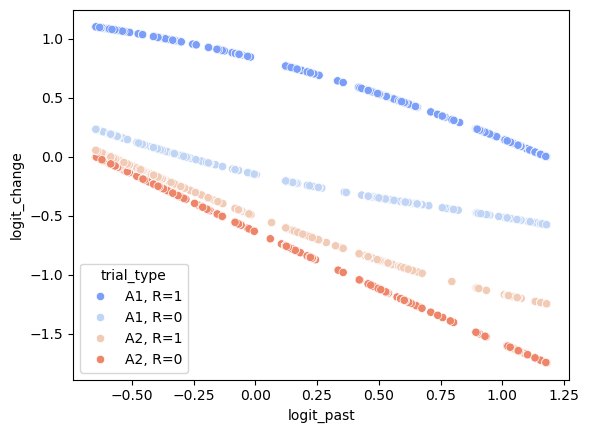

In [ ]:
labels = ['A1, R=0','A1, R=1', 'A2, R=0', 'A2, R=1']
trial_data['trial_type'] = [labels[i] for i in (trial_data['choice'] * 2 + trial_data['outcome'])]

colors = ["cornflowerblue", "mediumblue", "tomato", "firebrick"]


sns.scatterplot(trial_data,
                x='logit_past',y='logit_change', hue='trial_type',
                palette = 'coolwarm')

0      poke_6
1      poke_6
2      poke_6
3      poke_6
4      poke_6
        ...  
444    poke_6
445    poke_6
446    poke_6
447    poke_6
448    poke_6
Name: good_poke, Length: 7840, dtype: category
Categories (2, object): ['poke_4', 'poke_6']

0      1
1      1
2      1
3      1
4      1
      ..
444    1
445    1
446    1
447    1
448    1
Length: 7840, dtype: int8

In [22]:
model.eval()
trial_by_trial_data = {}
n_batches, n_seq, n_inputs = dataset.inputs.shape
n_trials = n_batches*n_seq
inputs_reshaped = dataset.inputs.reshape(n_trials,n_inputs).unsqueeze(0)

with torch.no_grad():
    predictions = model(inputs_reshaped)  
    if not model.rnn_type == 'vanilla': 
        if not model.input_forced_choice:
            inputs_reshaped = inputs_reshaped[:,:,1:]
        hidden_state, gate_activations = model.rnn(inputs_reshaped, return_gate_activations = True)
        # add hidden activations
        for each_unit in range(model.H):
            trial_by_trial_data[f'hidden_{each_unit+1}'] = hidden_state[:,:,each_unit].flatten()
        # add gate activations
        for gate_label, activations in gate_activations.items():
            for each_unit in range(activations.shape[-1]):
                trial_by_trial_data[f'gate_{gate_label}_{each_unit+1}'] = activations[:,:,each_unit].flatten()


In [ ]:
#info_df = pat.get_train_info_df()
#for train_info in info_df.itertuples():
#    pat.train_model_AB(train_info.data_path,str(train_info.save_path),train_info.model_type,train_info.hidden_size,train_info.nm_size,train_info.nm_dim,train_info.nm_mode)
#    break

info_df = pat.get_train_info_df()
info_df

,subject_ID,random_seed,model_type,hidden_size,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed
0,WS16,1,vanilla,1,1,1,row,1_unit_vanilla,NM_TinyRNN/data/rnns/WS16/random_seed_1/vanilla,NM_TinyRNN/data/AB_behaviour/WS16,True
1,WS16,1,vanilla,2,1,1,row,2_unit_vanilla,NM_TinyRNN/data/rnns/WS16/random_seed_1/vanilla,NM_TinyRNN/data/AB_behaviour/WS16,True
2,WS16,1,GRU,1,1,1,row,1_unit_GRU,NM_TinyRNN/data/rnns/WS16/random_seed_1/GRU,NM_TinyRNN/data/AB_behaviour/WS16,False
3,WS16,1,GRU,2,1,1,row,2_unit_GRU,NM_TinyRNN/data/rnns/WS16/random_seed_1/GRU,NM_TinyRNN/data/AB_behaviour/WS16,False
4,WS16,1,LSTM,1,1,1,row,1_unit_LSTM,NM_TinyRNN/data/rnns/WS16/random_seed_1/LSTM,NM_TinyRNN/data/AB_behaviour/WS16,False
...,...,...,...,...,...,...,...,...,...,...,...
115,WS16,10,NMRNN,1,2,1,low_rank,1_unit_NMRNN_2_subunits_1_low_rank,NM_TinyRNN/data/rnns/WS16/random_seed_10/NMRNN...,NM_TinyRNN/data/AB_behaviour/WS16,False
116,WS16,10,NMRNN,2,1,1,low_rank,2_unit_NMRNN_1_subunits_1_low_rank,NM_TinyRNN/data/rnns/WS16/random_seed_10/NMRNN...,NM_TinyRNN/data/AB_behaviour/WS16,False
117,WS16,10,NMRNN,2,2,1,low_rank,2_unit_NMRNN_2_subunits_1_low_rank,NM_TinyRNN/data/rnns/WS16/random_seed_10/NMRNN...,NM_TinyRNN/data/AB_behaviour/WS16,False
118,WS16,10,NMRNN,2,1,2,low_rank,2_unit_NMRNN_1_subunits_2_low_rank,NM_TinyRNN/data/rnns/WS16/random_seed_10/NMRNN...,NM_TinyRNN/data/AB_behaviour/WS16,False


In [ ]:
from NM_TinyRNN.code.models import parallelised_training as patpat.

<Axes: xlabel='hidden_size', ylabel='eval_CE'>

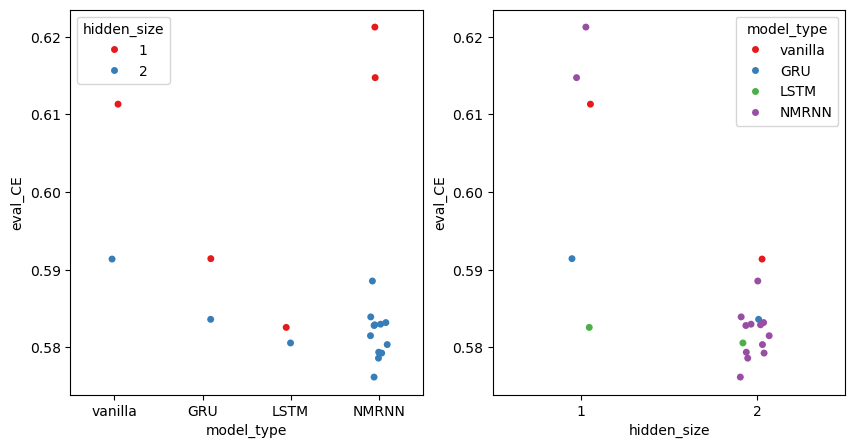

In [24]:
## Brief performance comparison across models

# we've pretrained some models on the test data using parallelised training code:
from NM_TinyRNN.code.models import parallelised_training as pat
import json

info_df = pat.get_train_info_df()
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    eval_json_path = model_dir / f'{model_info.model_id}_info.json'
    if eval_json_path.exists():
        with open(eval_json_path, 'r') as f:
            eval_info = json.load(f)
        info_df.loc[info_df.model_id==model_info.model_id, 'eval_CE'] = eval_info['eval_pred_loss']

fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.stripplot(
    data=info_df,  
    y='eval_CE', 
    x='model_type',
    hue='hidden_size',
    jitter=True,
    dodge=False, palette='Set1', ax = ax[0]
)
sns.stripplot(
    data=info_df,  
    y='eval_CE', 
    x='hidden_size',
    hue='model_type',
    jitter=True,
    dodge=False,
    palette='Set1', ax = ax[1]
)

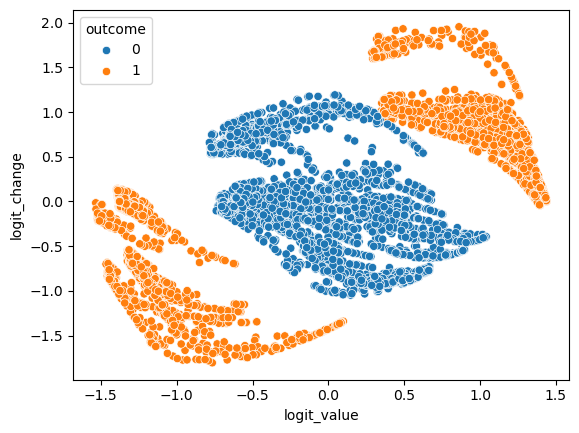

<Axes: xlabel='gate_reset_1', ylabel='gate_update_1'>

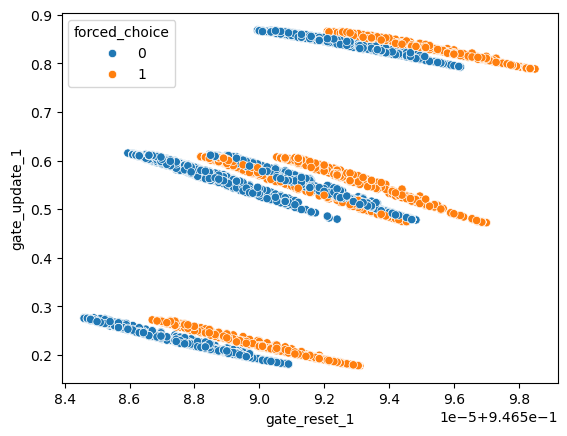

In [38]:
# Now we can visualise the logits across all the models:
trial_dfs = {}
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    trials_df = model_dir / f'{model_info.model_id}_trials_data.htsv'
    trials_df = pd.read_csv(trials_df, sep='\t')
    trials_df.loc[:,'model_id'] = model_info.model_id
    trials_df.loc[:,'model_type'] = model_info.model_type
    trials_df.loc[:,'hidden_size'] = model_info.hidden_size
    trials_df.loc[:,'nm_size'] = model_info.nm_size
    trials_df.loc[:,'nm_dim'] = model_info.nm_dim
    trials_df.loc[:,'nm_mode'] = model_info.nm_mode
    trial_dfs[model_info.model_id] = trials_df

trials_results = trial_dfs['2_unit_GRU']
import seaborn as sns
trials_results['trial_type'] = trials_results['choice'] * 2 + trials_results['outcome']
sns.scatterplot(trials_results, x= 'logit_value',y='logit_change', hue='outcome')
plt.show()
sns.scatterplot(trials_results, x='gate_reset_1', y = 'gate_update_1', hue = 'forced_choice')

In [106]:
trial_dfs['1_unit_GRU']

,hidden_1,gate_reset_1,gate_update_1,logit_value,logit_change,prob_A,prob_b,forced_choice,outcome,choice,indices_train,indices_validation,indices_evaluation,session_folder_name,model_id,model_type,hidden_size,nm_size,nm_dim,nm_mode
0,-0.577176,0.833123,0.055723,1.196371,NaN,0.767879,0.232121,1,1,0,True,False,False,2025-05-01-164959,1_unit_GRU,GRU,1,1,1,row
1,-0.687692,0.491261,0.061082,1.369987,0.173617,0.797378,0.202622,0,1,0,True,False,False,2025-05-01-164959,1_unit_GRU,GRU,1,1,1,row
2,-0.135772,0.093897,0.479391,0.502943,-0.867045,0.623151,0.376849,0,0,0,True,False,False,2025-05-01-164959,1_unit_GRU,GRU,1,1,1,row
3,0.127429,0.081557,0.529370,0.089464,-0.413478,0.522351,0.477649,0,0,0,True,False,False,2025-05-01-164959,1_unit_GRU,GRU,1,1,1,row
4,0.581314,0.765910,0.377894,-0.623572,-0.713037,0.348969,0.651031,1,1,1,True,False,False,2025-05-01-164959,1_unit_GRU,GRU,1,1,1,row
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,0.190791,0.079064,0.540254,-0.010076,-0.323434,0.497481,0.502519,0,0,0,False,True,False,2025-04-28-181702,1_unit_GRU,GRU,1,1,1,row
7646,0.268601,0.250625,0.901551,-0.132312,-0.122236,0.466970,0.533030,1,0,1,False,True,False,2025-04-28-181702,1_unit_GRU,GRU,1,1,1,row
7647,-0.345211,0.432514,0.081220,0.831963,0.964275,0.696770,0.303230,0,1,0,False,True,False,2025-04-28-181702,1_unit_GRU,GRU,1,1,1,row
7648,-0.227338,0.060104,0.911090,0.646789,-0.185174,0.656286,0.343714,0,0,1,False,True,False,2025-04-28-181702,1_unit_GRU,GRU,1,1,1,row


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

trials_results = trial_dfs['1_unit_NMRNN_1_subunits_1_low_rank'] #.query('forced_choice == 0')
df = trials_results
df['logit_past'] = np.concat([[np.nan], df['logit_value'].values[:-1]])
df = df.dropna(subset=['logit_value', 'logit_change']).copy()
labels = ['A1, R=0','A1, R=1', 'A2, R=0', 'A2, R=1']
df['trial_type'] = [labels[i] for i in (df['choice'] * 2 + df['outcome'])]

colors = ["cornflowerblue", "mediumblue", "tomato", "firebrick"]

sns.scatterplot(df, 'logit_past')

KeyError: '1_unit_NMRNN_1_subunits_1_low_rank'

<Axes: xlabel='logit_past', ylabel='logit_change'>

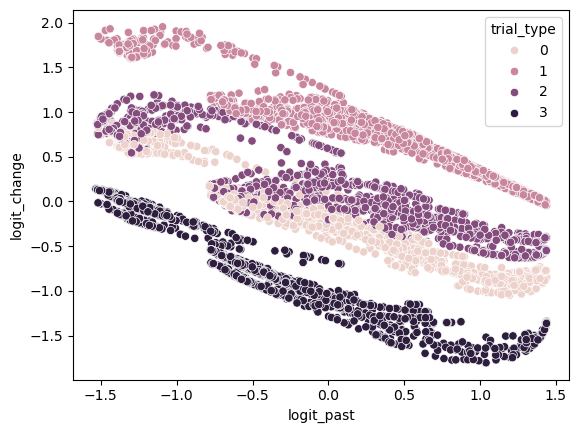

In [92]:
trial_dfs.keys()

dict_keys(['1_unit_vanilla', '2_unit_vanilla', '1_unit_GRU', '2_unit_GRU', '1_unit_LSTM', '2_unit_LSTM', '1_unit_NMRNN_1_subunits_1_row', '1_unit_NMRNN_2_subunits_1_row', '2_unit_NMRNN_1_subunits_1_low_rank', '2_unit_NMRNN_1_subunits_1_row', '2_unit_NMRNN_1_subunits_1_column', '2_unit_NMRNN_2_subunits_1_low_rank', '2_unit_NMRNN_2_subunits_1_row', '2_unit_NMRNN_2_subunits_1_column', '2_unit_NMRNN_1_subunits_2_low_rank', '2_unit_NMRNN_1_subunits_2_row', '2_unit_NMRNN_1_subunits_2_column', '2_unit_NMRNN_2_subunits_2_low_rank', '2_unit_NMRNN_2_subunits_2_row', '2_unit_NMRNN_2_subunits_2_column'])

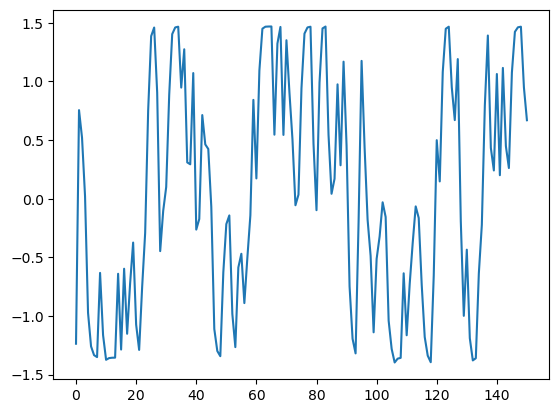

In [93]:
#plt.plot(trial_results.loc[:150,'hidden'])
plt.plot(trial_results.loc[:150,'logit_value'])

In [ ]:
df = dataset.subject_df[]
df['trial_type']

In [16]:
# Extract trial-wise data for visualisation
trials_results = pd.read_csv('.data/rnns/GRU/2_unit_GRU_trials_data.htsv', sep='\t')
trials_inputs = dataset.inputs.reshape(-1, 3).numpy().astype(int)
trials_results.loc[:, ["forced_choice","outcome", "choice"]] = trials_inputs # "forced_choice","outcome","choice"
trials_results

FileNotFoundError: [Errno 2] No such file or directory: '.data/rnns/GRU/2_unit_GRU_trials_data.htsv'